In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras import layers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from keras.applications import MobileNet
from keras.regularizers import l2

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import keras_tuner
from keras_tuner.tuners import GridSearch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 9.4 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Fri May 26 07:14:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [ ]:
PATH = "/content/drive/MyDrive/Datasets/Garbage_Classification"

DATASET = image_dataset_from_directory(
    PATH,
    labels = "inferred",
    label_mode = "categorical",
    batch_size = 16,
    image_size = (224, 224),
    seed = 42,
    shuffle = True
)

Found 1393 files belonging to 3 classes.


In [ ]:
print(f"Number of classes in the dataset: {len(DATASET.class_names)}")

# Sampling the Subsets
TOTAL_S = DATASET.cardinality().numpy()
TRAIN_S = int(0.7 * TOTAL_S)  # 70% for train
TEST_S = int(0.15 * TOTAL_S)   # 15% for test
VAL_S = TOTAL_S - TRAIN_S - TEST_S  # %15 for validation

AUTOTUNE = tf.data.AUTOTUNE
TRAIN = DATASET.take(TRAIN_S).prefetch(buffer_size = AUTOTUNE)
TEST = DATASET.skip(TRAIN_S).take(TEST_S).prefetch(buffer_size = AUTOTUNE)
VAL = DATASET.skip(TRAIN_S + TEST_S).take(VAL_S).prefetch(buffer_size = AUTOTUNE)

Number of classes in the dataset: 3


In [ ]:
# Model-Building
INPUT_SHAPE = (224, 224, 3)
ACTIVATION = "sigmoid"

DATA_GEN_LAYER = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape = INPUT_SHAPE),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
  ]
)


# Building the Custom Model Architecture
def buildModel(HP):
    MODEL = keras.Sequential()
    MODEL.add(DATA_GEN_LAYER)
    
    BASE = MobileNet(weights = "imagenet", include_top = False, input_shape = INPUT_SHAPE)
    BASE.trainable = False
    
    MODEL.add(BASE)
    MODEL.add(layers.GlobalAveragePooling2D())
    MODEL.add(layers.Dense(64, activation = "relu"))
    MODEL.add(layers.Dropout(0.25))
    MODEL.add(layers.Dense(3, activation = ACTIVATION))
    
    # Hyperparameter grid
    LEARNING_RATE = HP.Choice("learning_rate", [0.001, 0.01, 0.1])
    OPTIMIZER = HP.Choice("optimizer", ["adam", "rmsprop","sgd"])
    EPOCH = HP.Choice("epoch", [50, 100, 150, 200, 250])
    BATCH_SIZE = HP.Choice("batch_size", [16, 32, 64])
    
    # Compiling the model
    MODEL.compile(optimizer = OPTIMIZER,
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])
    
    return MODEL

In [ ]:
# Grid Search for the Best Hyper-Parameters

TUNER = GridSearch(
    hypermodel = buildModel,
    objective = "val_accuracy",
    max_trials = 3,
    directory = "/content/drive/MyDrive/Models",
    project_name = "GCTuner_MODEL",  # Garbage Classification Tuner
)

TUNER.search(
    TRAIN,
    validation_data = VAL,
    epochs = 10,
    verbose = 1,
)

Trial 3 Complete [00h 01m 11s]
val_accuracy: 0.6846473217010498

Best val_accuracy So Far: 0.6929460763931274
Total elapsed time: 00h 03m 54s


In [ ]:
# Getting the Best Hyper-Parameter Values
HP_BEST = TUNER.get_best_hyperparameters()[0]
LR_BEST = HP_BEST.get("learning_rate")
EPOCH_BEST = HP_BEST.get("epoch")
BATCHS_B = HP_BEST.get("batch_size")
OPTIMIZER_BEST = HP_BEST.get("optimizer")

In [ ]:
# Table of Best Hyper-Parameter Values
BESTHP_DF = pd.DataFrame(
    {
    "Learning Rate": [LR_BEST],
    "Epochs": [EPOCH_BEST],
    "Batch Size": [BATCHS_B],
    "Optimizer": [OPTIMIZER_BEST],
     },
     index = ["Results"]
)

BESTHP_DF

,Learning Rate,Epochs,Batch Size,Optimizer
Results,0.001,50,16,adam


In [ ]:
# Model Training
MODEL = buildModel(HP_BEST)

HISTORY = MODEL.fit(
    TRAIN,
    batch_size = BATCHS_B,
    epochs = EPOCH_BEST,
    validation_data = VAL,
)

Epoch 1/50
30/30 [==============================] - 10s 228ms/step - loss: 1.1073 - accuracy: 0.4708 - val_loss: 0.9727 - val_accuracy: 0.5311
Epoch 2/50
30/30 [==============================] - 6s 169ms/step - loss: 0.9577 - accuracy: 0.5490 - val_loss: 0.8750 - val_accuracy: 0.6224
Epoch 3/50
30/30 [==============================] - 7s 219ms/step - loss: 0.8894 - accuracy: 0.5927 - val_loss: 0.8551 - val_accuracy: 0.6058
Epoch 4/50
30/30 [==============================] - 8s 250ms/step - loss: 0.8746 - accuracy: 0.5990 - val_loss: 0.8481 - val_accuracy: 0.6556
Epoch 5/50
30/30 [==============================] - 6s 174ms/step - loss: 0.8606 - accuracy: 0.6135 - val_loss: 0.8227 - val_accuracy: 0.6183
Epoch 6/50
30/30 [==============================] - 8s 250ms/step - loss: 0.8176 - accuracy: 0.6323 - val_loss: 0.8743 - val_accuracy: 0.6224
Epoch 7/50
30/30 [==============================] - 6s 172ms/step - loss: 0.8131 - accuracy: 0.6427 - val_loss: 0.7578 - val_accuracy: 0.6929
Epoch

In [ ]:
MODEL.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                65600     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                

In [ ]:
HISTORY.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
MODEL.save("/content/drive/MyDrive/Models/MODEL.h5")

In [ ]:
# Extracting Labels for TEST Set
TRUE_LABELS = []
IMAGES = []

for _, LABELS in TEST:
  LABELS_IDX = tf.argmax(LABELS, axis = 1)
  IMAGES.append(_)
  L = [DATASET.class_names[label] for label in LABELS_IDX]
  TRUE_LABELS.extend(L)

# Formatting Predtion Outputs
Y_PRED = MODEL.predict(TEST)

MAP = {
    0: "Glass",
    1: "Metal",
    2: "Plastic"
}
Y_PRED = np.argmax(Y_PRED, axis = 1)
Y_PRED = [MAP[label] for label in Y_PRED]
Y_PRED = np.array(Y_PRED)

# Extarting the True Labels
Y_TRUE = np.array(TRUE_LABELS)

6/6 [==============================] - 3s 103ms/step


6/6 [==============================] - 3s 64ms/step


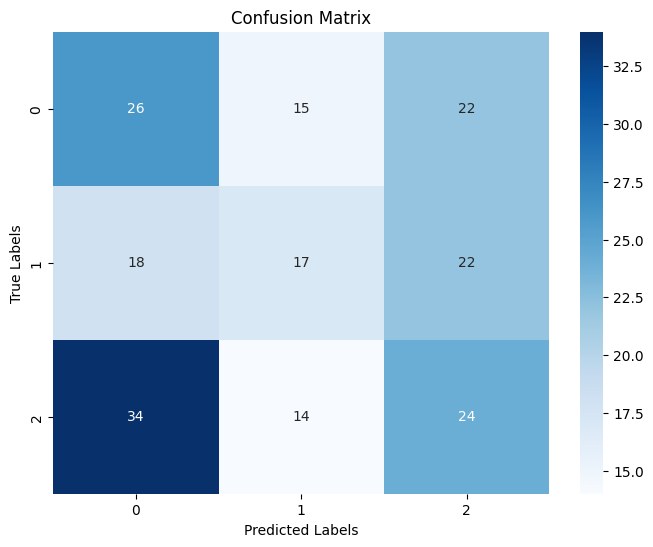

In [ ]:
CM = confusion_matrix(Y_TRUE, Y_PRED)

# Plotting CM
plt.figure(figsize = (8, 6))
sns.heatmap(CM, annot = True, cmap = "Blues", fmt = "g", cbar = True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

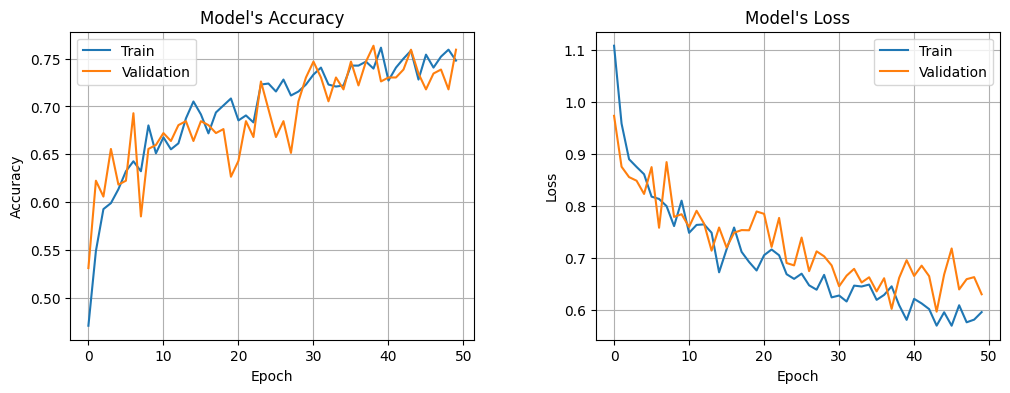

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
axs[0].plot(HISTORY.history["accuracy"])
axs[0].plot(HISTORY.history["val_accuracy"])
axs[0].set_title("Model's Accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].legend(["Train", "Validation"], loc="upper left")
axs[0].grid()

# Loss
axs[1].plot(HISTORY.history["loss"])
axs[1].plot(HISTORY.history["val_loss"])
axs[1].set_title("Model's Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].legend(["Train", "Validation"], loc="upper right")
axs[1].grid()

plt.subplots_adjust(wspace = 0.3)

plt.show()